In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import requests
from typing import List, Optional, Union
import io
import chess.pgn
import chess.variant
from tqdm import tqdm

import src.ModuleLoader
ml = src.ModuleLoader.ModuleLoader()

connection = sqlite3.connect('./puzzles.db')
cursor = connection.cursor()

In [ ]:
# Define a function to get game data

def get_game_pgn(game_id: str) -> Optional[str]:
    """
    Fetches a chess game from Lichess and returns its PGN content.
    
    Args:
        game_id (str): The ID of the game to fetch
        
    Returns:
        Optional[str]: The game content in PGN format, or None if the request fails
        
    Raises:
        ValueError: If the game_id is empty or invalid
    """
    base_url = "https://lichess.org/game/export/"

    if not game_id or not isinstance(game_id, str):
        raise ValueError("Invalid game_id provided")
        
    try:
        full_url = f"{base_url}{game_id}?clocks=true"
        response = requests.get(full_url)
        
        if response.status_code == 200:
            return response.text
        else:
            print(f"Failed to fetch game. Status code: {response.status_code}")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"Error fetching game: {e}")
        return None


def export_lichess_games(game_ids: List[str], token: Optional[str] = None) -> str:
    """
    Export multiple Lichess games using their IDs.
    
    Args:
        game_ids: List of Lichess game IDs to export
        token: Optional OAuth token for authentication
        
    Returns:
        str: PGN string containing all requested games
        
    Raises:
        ValueError: If game_ids is empty or contains invalid IDs
        requests.RequestException: If the API request fails
    """
    # Validate inputs
    if not game_ids:
        raise ValueError("At least one game ID must be provided")
        
    # Join game IDs with commas
    ids_string = ",".join(game_ids)
    
    # Set up headers
    headers = {
        "Content-Type": "text/plain",
    }
    
    # Add authorization header if token is provided
    if token:
        headers["Authorization"] = f"Bearer {token}"
    
    try:
        response = requests.post(
            "https://lichess.org/api/games/export/_ids?clocks=true",
            data=ids_string,
            headers=headers,
            # timeout=30  # 30-second timeout
        )
        
        response.raise_for_status()
        return response.text
        
    except requests.exceptions.HTTPError as http_err:
        raise requests.exceptions.HTTPError(f"Lichess API returned error: {response.text}") from http_err
    except Exception as err:
        raise Exception(f"Failed to export games: {err}") from err


In [ ]:
cursor.execute('''
    SELECT 
        puzzles.id,
        games.gameId
    FROM puzzles
    JOIN games ON puzzles.gameId = games.id
    WHERE puzzles.moveTime <= 0
''')

puzzles = cursor.fetchall()
games = [p[1] for p in puzzles]

games_order = []

for game in tqdm(games):
    games_order.append(game)

    if len(games_order) >= 300:
        d = export_lichess_games(games_order)
        #print(d)
        data = io.StringIO(d)

        g = chess.pgn.read_game(data)

        while g is not None:
            puzzle = ml.Puzzle.Puzzle(ml, connection, searchByGameId=g.headers['GameId'])

            tc = int(g.headers['TimeControl'].split('+')[1])
            goal = chess.variant.AntichessBoard(puzzle.fen)

            while g.ply() <= goal.ply():
                g = g.next()

                if g is None:
                    break
            
            if g is not None:
                if g.next() is not None and g.clock() is not None:
                    if g.next().next() is not None:
                        if g.next().next().clock() is not None:
                            moveTime = g.clock() - g.next().next().clock() + tc
                            puzzle.moveTime = moveTime

                            puzzle.update_database_entry()
        
            g = chess.pgn.read_game(data)

        games_order = []


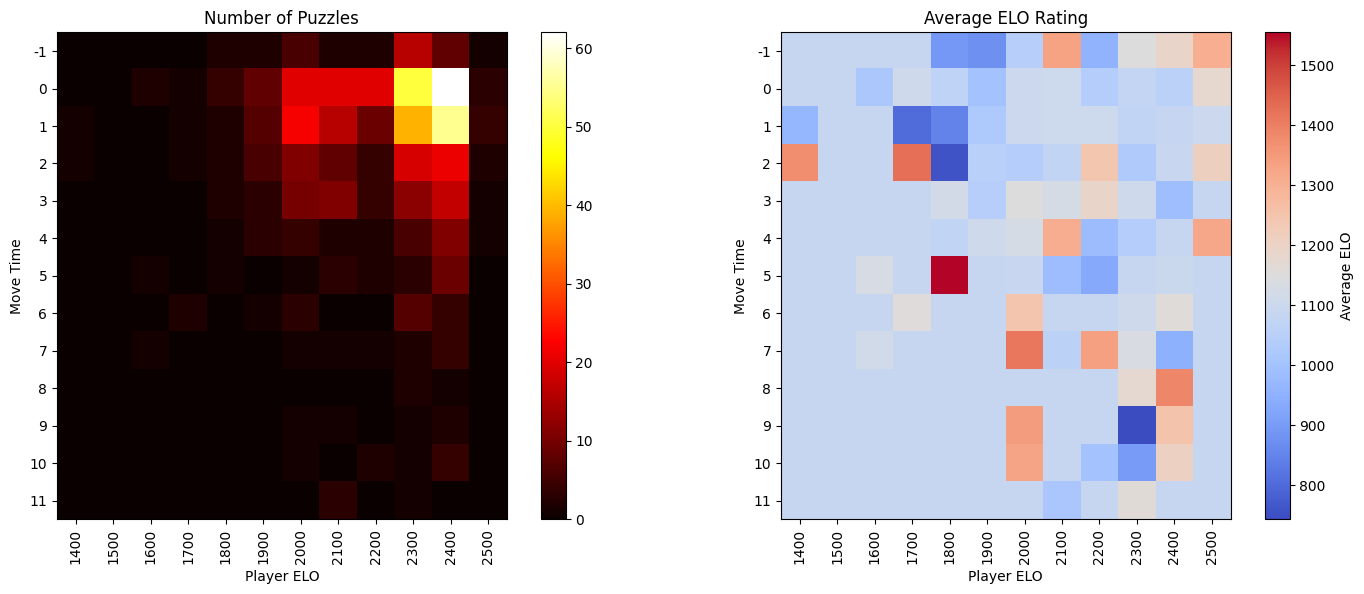

In [56]:
cursor.execute('''
    SELECT
        puzzles.elo,
        puzzles.moveTime,
        games.WhiteElo,
        games.BlackElo,
        puzzles.turn
    FROM puzzles
    JOIN games ON puzzles.gameId = games.id
    WHERE puzzles.elodev != 350
    AND (
        SELECT COUNT(*) 
        FROM played 
        WHERE played.puzzleId = puzzles.id
    ) >= 3;
''')

data = cursor.fetchall()

max_elo = 2500
min_elo = 1400
step_elo = 100

max_time = 11
min_time = -1
step_time = 1

bins = [[0 for _ in range(int((max_elo - min_elo) / step_elo) + 1)] for _ in range(int((max_time - min_time) / step_time) + 1)]
count = [[0 for _ in range(int((max_elo - min_elo) / step_elo) + 1)] for _ in range(int((max_time - min_time) / step_time) + 1)]

average = 0
count_average = 0

for d in data:
    elo = d[0]
    time = d[1]
    playerElo = d[2] if d[4] == 1 else d[3]

    if time < min_time or time > max_time or playerElo < min_elo or playerElo > max_elo:
        continue

    average += elo
    count_average += 1

    bins[round((time - min_time) / step_time)][round((playerElo - min_elo) / step_elo)] += elo
    count[round((time - min_time) / step_time)][round((playerElo - min_elo) / step_elo)] += 1

average /= count_average

# Create figure with two subplots side by side
plt.figure(figsize=(15, 6))

# First subplot (existing count plot)
plt.subplot(1, 2, 1)
plt.imshow(count, cmap='hot', interpolation='nearest')
plt.yticks(range(int((max_time - min_time) / step_time) + 1),
           [i * step_time + min_time for i in range(int((max_time - min_time) / step_time) + 1)])
plt.xticks(range(int((max_elo - min_elo) / step_elo) + 1),
           [i * step_elo + min_elo for i in range(int((max_elo - min_elo) / step_elo) + 1)],
           rotation=90)
plt.colorbar()
plt.ylabel('Move Time')
plt.xlabel('Player ELO')
plt.title('Number of Puzzles')

# Second subplot (average ELO plot)
plt.subplot(1, 2, 2)
# Calculate average ELO values where there are moves
avg_elo = [[bins[i][j]/count[i][j] if count[i][j] > 0 else average 
            for j in range(len(bins[0]))] 
           for i in range(len(bins))]
plt.imshow(avg_elo, cmap='coolwarm', interpolation='nearest')
plt.yticks(range(int((max_time - min_time) / step_time) + 1),
           [i * step_time + min_time for i in range(int((max_time - min_time) / step_time) + 1)])
plt.xticks(range(int((max_elo - min_elo) / step_elo) + 1),
           [i * step_elo + min_elo for i in range(int((max_elo - min_elo) / step_elo) + 1)],
           rotation=90)
plt.colorbar(label='Average ELO')
plt.ylabel('Move Time')
plt.xlabel('Player ELO')
plt.title('Average ELO Rating')

plt.tight_layout()
plt.show()